こちらの方のほぼ写経 // this notebook is copied and modified from the link below.

https://www.kaggle.com/ruchi798/commonlit-readability-prize-eda-baseline/comments#Pre-processing-excerpt-%E2%9C%82%EF%B8%8F

# Set up

In [26]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

import pandas_profiling as pdp
import matplotlib.pyplot as plt
import seaborn as sns

import re

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk import pos_tag

from wordcloud import WordCloud,STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer as CV
from sklearn.feature_extraction.text import TfidfVectorizer


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/misawamasafumi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/misawamasafumi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/misawamasafumi/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


# Load Data

In [5]:
train_df = pd.read_csv("../datasets/train.csv")
test_df = pd.read_csv("../datasets/test.csv")
# sample = pd.read_csv("../datasets/sample_submission.csv")

# Profile data

In [6]:
train_df.head()

id url_legal license  \
0  c12129c31       NaN     NaN   
1  85aa80a4c       NaN     NaN   
2  b69ac6792       NaN     NaN   
3  dd1000b26       NaN     NaN   
4  37c1b32fb       NaN     NaN   

                                             excerpt    target  standard_error  
0  When the young people returned to the ballroom... -0.340259        0.464009  
1  All through dinner time, Mrs. Fayre was somewh... -0.315372        0.480805  
2  As Roger had predicted, the snow departed as q... -0.580118        0.476676  
3  And outside before the palace a great garden w... -1.054013        0.450007  
4  Once upon a time there were Three Bears who li...  0.247197        0.510845

In [7]:
train_df.excerpt[0]

'When the young people returned to the ballroom, it presented a decidedly changed appearance. Instead of an interior scene, it was a winter landscape.\nThe floor was covered with snow-white canvas, not laid on smoothly, but rumpled over bumps and hillocks, like a real snow field. The numerous palms and evergreens that had decorated the room, were powdered with flour and strewn with tufts of cotton, like snow. Also diamond dust had been lightly sprinkled on them, and glittering crystal icicles hung from the branches.\nAt each end of the room, on the wall, hung a beautiful bear-skin rug.\nThese rugs were for prizes, one for the girls and one for the boys. And this was the game.\nThe girls were gathered at one end of the room and the boys at the other, and one end was called the North Pole, and the other the South Pole. Each player was given a small flag which they were to plant on reaching the Pole.\nThis would have been an easy matter, but each traveller was obliged to wear snowshoes.'

excerpt (抜粋) から、人によってつけられた文章の読みやすさスコアみたいなの（target）をを当てる

スコアは複数人でつけるため、人による採点ばらつき（standard error）がある

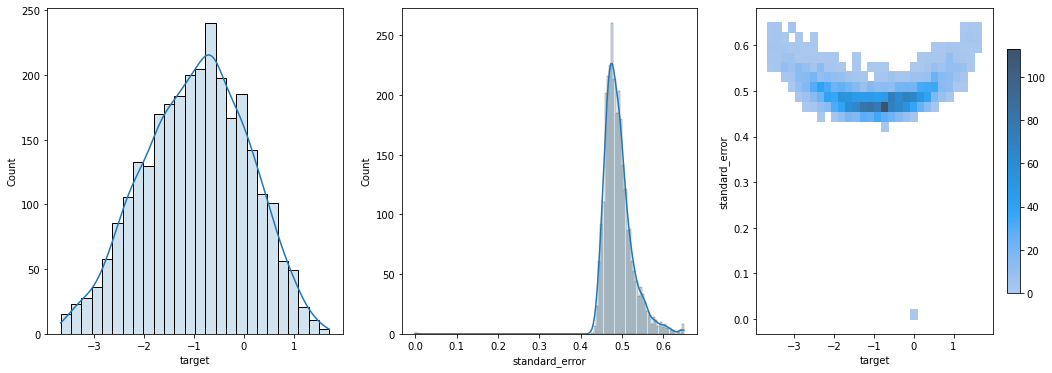

In [8]:
fig, ax = plt.subplots(1,3,figsize=(18,6))

sns.histplot(train_df['target'], ax=ax[0], kde=True, alpha=0.2)
sns.histplot(train_df['standard_error'], ax=ax[1], kde=True, alpha=0.2)

sns.histplot(
    train_df, x="target", y="standard_error",
    bins=30, discrete=(False, False), log_scale=(False, False),
    cbar=True, cbar_kws=dict(shrink=.75), 
    ax=ax[2]
)
plt.show()

In [9]:
test_df.head()

id                                    url_legal       license  \
0  c0f722661                                          NaN           NaN   
1  f0953f0a5                                          NaN           NaN   
2  0df072751                                          NaN           NaN   
3  04caf4e0c  https://en.wikipedia.org/wiki/Cell_division  CC BY-SA 3.0   
4  0e63f8bea      https://en.wikipedia.org/wiki/Debugging  CC BY-SA 3.0   

                                             excerpt  
0  My hope lay in Jack's promise that he would ke...  
1  Dotty continued to go to Mrs. Gray's every nig...  
2  It was a bright and cheerful scene that greete...  
3  Cell division is the process by which a parent...  
4  Debugging is the process of finding and resolv...

In [7]:
# profile = pdp.ProfileReport(train_df)
# profile

Summarize dataset:   0%|          | 0/19 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

url, license は、訓練データの 70% が欠損している

In [8]:
# pdp.ProfileReport(test_df)

Summarize dataset:   0%|          | 0/17 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
for idx,row in train_df.sort_values(by=['target'], ascending=False).head(3).iterrows():
    print('index:' + str(idx) + ', target ' + str(row.target))
    print(row.excerpt + '\n')

index:2829, target 1.711389827
When you think of dinosaurs and where they lived, what do you picture? Do you see hot, steamy swamps, thick jungles, or sunny plains? Dinosaurs lived in those places, yes. But did you know that some dinosaurs lived in the cold and the darkness near the North and South Poles?
This surprised scientists, too. Paleontologists used to believe that dinosaurs lived only in the warmest parts of the world. They thought that dinosaurs could only have lived in places where turtles, crocodiles, and snakes live today. Later, these dinosaur scientists began finding bones in surprising places.
One of those surprising fossil beds is a place called Dinosaur Cove, Australia. One hundred million years ago, Australia was connected to Antarctica. Both continents were located near the South Pole. Today, paleontologists dig dinosaur fossils out of the ground. They think about what those ancient bones must mean.

index:981, target 1.597869841
For her last birthday, Sisanda had a

In [11]:
for idx,row in train_df.sort_values(by=['target'], ascending=False).tail(3).iterrows():
    print('index:' + str(idx) + ', target ' + str(row.target))
    print(row.excerpt + '\n')

index:1754, target -3.64289216
The iron cylinder weighs 23 kilogrammes; but, when the current has an intensity of 43 amperes and traverses 15 sections, the stress developed may reach 70 kilogrammes; that is to say, three times the weight of the hammer. So this latter obeys with absolute docility the motions of the operator's hands, as those who were present at the lecture were enabled to see. I will incidentally add that this power hammer was placed on a circuit derived from one that served likewise to supply three Hefner-Alteneck machines (Siemens D5 model) and a Gramme machine (Breguet model P.L.). Each of these machines was making 1,500 revolutions per minute and developing 25 kilogrammeters per second, measured by means of a Carpentier brake. All these apparatuses were operating with absolute independence, and had for generators the double excitation machine that figured at the Exhibition of Electricity. In an experiment made since then, I have succeeded in developing in each of th

# Preprocess Data
以下の流れで処理
1. 文章内のアルファベット以外を空白に変換
2. stopwords の削除
3. 単語のレンマ化

In [12]:
excerpt1 = train_df['excerpt'].min()
print("Before preprocessing: \n")
print(excerpt1)

Before preprocessing: 

"'Morning, Jeeves," I said.
"Good morning, sir," said Jeeves. He put the good old cup of tea softly on the table by my bed, and I took a refreshing sip. Just right, as usual. Not too hot, not too sweet, not too weak, not too strong, not too much milk, and not a drop spilled in the saucer. A most amazing cove, Jeeves. So dashed competent in every respect. I've said it before, and I'll say it again. I mean to say, take just one small instance. Every other valet I've ever had used to barge into my room in the morning while I was still asleep, causing much misery: but Jeeves seems to know when I'm awake by a sort of telepathy. He always floats in with the cup exactly two minutes after I come to life. Makes a deuce of a lot of difference to a fellow's day.
"How's the weather, Jeeves?" 
"Exceptionally clement, sir."
"Anything in the papers?"
"Some slight friction threatening in the Balkans, sir. Otherwise, nothing."


In [17]:
# re.sub(): 正規表現で置換
e = re.sub("[^a-zA-Z]", " ", excerpt1) # アルファベット以外は空白に変換
e = e.lower() # 小文字に変換
e = nltk.word_tokenize(e) # tokenizer を使って単語に分割
e[:8]

['morning', 'jeeves', 'i', 'said', 'good', 'morning', 'sir', 'said']

In [18]:
e

['morning',
 'jeeves',
 'i',
 'said',
 'good',
 'morning',
 'sir',
 'said',
 'jeeves',
 'he',
 'put',
 'the',
 'good',
 'old',
 'cup',
 'of',
 'tea',
 'softly',
 'on',
 'the',
 'table',
 'by',
 'my',
 'bed',
 'and',
 'i',
 'took',
 'a',
 'refreshing',
 'sip',
 'just',
 'right',
 'as',
 'usual',
 'not',
 'too',
 'hot',
 'not',
 'too',
 'sweet',
 'not',
 'too',
 'weak',
 'not',
 'too',
 'strong',
 'not',
 'too',
 'much',
 'milk',
 'and',
 'not',
 'a',
 'drop',
 'spilled',
 'in',
 'the',
 'saucer',
 'a',
 'most',
 'amazing',
 'cove',
 'jeeves',
 'so',
 'dashed',
 'competent',
 'in',
 'every',
 'respect',
 'i',
 've',
 'said',
 'it',
 'before',
 'and',
 'i',
 'll',
 'say',
 'it',
 'again',
 'i',
 'mean',
 'to',
 'say',
 'take',
 'just',
 'one',
 'small',
 'instance',
 'every',
 'other',
 'valet',
 'i',
 've',
 'ever',
 'had',
 'used',
 'to',
 'barge',
 'into',
 'my',
 'room',
 'in',
 'the',
 'morning',
 'while',
 'i',
 'was',
 'still',
 'asleep',
 'causing',
 'much',
 'misery',
 'but',
 'j

In [21]:
e = [word for word in e if not word in set(stopwords.words("english"))] # stopwords に登録されている単語は除外する
stopwords.words("english")[:10] # ちなみに stopwords に登録されている単語はこんなの

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [23]:
# stopwords.words("english")

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [28]:
lemma = nltk.WordNetLemmatizer()
e = [lemma.lemmatize(word) for word in e] # lemmatizer を使ってlemmatizeする
nltk.WordNetLemmatizer().lemmatize("dogs") # lemmatize の例 dogs -> dog

'dog'

In [29]:
e

['morning',
 'jeeves',
 'said',
 'good',
 'morning',
 'sir',
 'said',
 'jeeves',
 'put',
 'good',
 'old',
 'cup',
 'tea',
 'softly',
 'table',
 'bed',
 'took',
 'refreshing',
 'sip',
 'right',
 'usual',
 'hot',
 'sweet',
 'weak',
 'strong',
 'much',
 'milk',
 'drop',
 'spilled',
 'saucer',
 'amazing',
 'cove',
 'jeeves',
 'dashed',
 'competent',
 'every',
 'respect',
 'said',
 'say',
 'mean',
 'say',
 'take',
 'one',
 'small',
 'instance',
 'every',
 'valet',
 'ever',
 'used',
 'barge',
 'room',
 'morning',
 'still',
 'asleep',
 'causing',
 'much',
 'misery',
 'jeeves',
 'seems',
 'know',
 'awake',
 'sort',
 'telepathy',
 'always',
 'float',
 'cup',
 'exactly',
 'two',
 'minute',
 'come',
 'life',
 'make',
 'deuce',
 'lot',
 'difference',
 'fellow',
 'day',
 'weather',
 'jeeves',
 'exceptionally',
 'clement',
 'sir',
 'anything',
 'paper',
 'slight',
 'friction',
 'threatening',
 'balkan',
 'sir',
 'otherwise',
 'nothing']

In [30]:
e=" ".join(e)
print("After preprocessing: \n")
print(e)

After preprocessing: 

morning jeeves said good morning sir said jeeves put good old cup tea softly table bed took refreshing sip right usual hot sweet weak strong much milk drop spilled saucer amazing cove jeeves dashed competent every respect said say mean say take one small instance every valet ever used barge room morning still asleep causing much misery jeeves seems know awake sort telepathy always float cup exactly two minute come life make deuce lot difference fellow day weather jeeves exceptionally clement sir anything paper slight friction threatening balkan sir otherwise nothing


In [16]:
def preprocess(data):
    excerpt_processed=[]
    lemma = nltk.WordNetLemmatizer()
    for e in data['excerpt']:
        e = re.sub("[^a-zA-Z]", " ", e) # アルファベット以外は空白に変換
        e = e.lower() # 小文字に変換
        e = nltk.word_tokenize(e) # tokenizer を使って単語に分割
        e = [word for word in e if not word in set(stopwords.words("english"))] # stopwords に登録されている単語は除外する
        e = [lemma.lemmatize(word) for word in e] # lemmatizer を使って lemmatize する
        e=" ".join(e)
        excerpt_processed.append(e)
    return excerpt_processed 

In [17]:
train_df['preprocessed_excerpt'] = preprocess(train_df)
test_df['preprocessed_excerpt'] = preprocess(test_df)

# 時間がかかるので、保存しておく
train_df.to_csv("train_excerpt_preprocessed.csv")
test_df.to_csv("test_excerpt_preprocessed.csv")

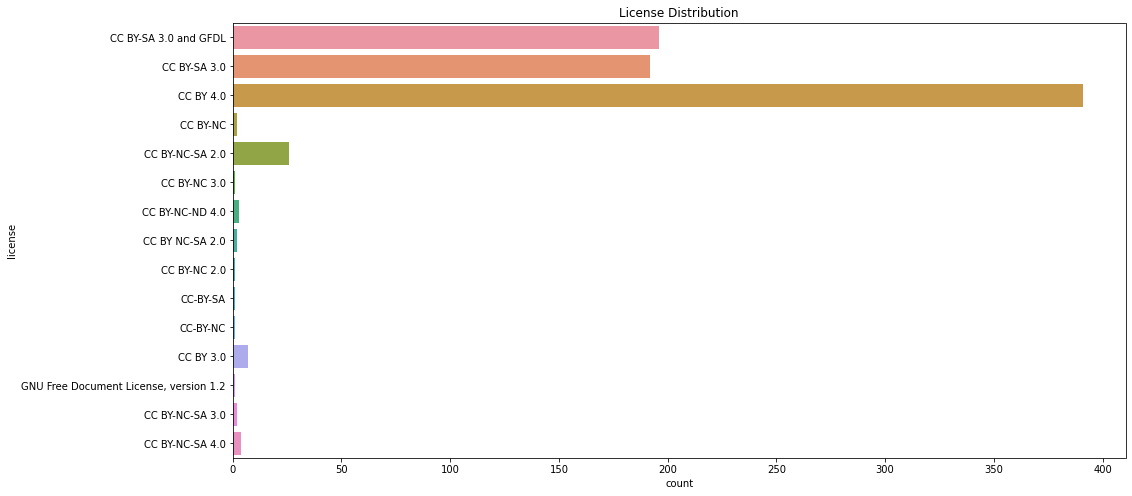

In [18]:
plt.figure(figsize=(16, 8))
sns.countplot(y="license",data=train_df,linewidth=3)
plt.title("License Distribution")
plt.show()

頻出単語(unigram), 頻出bigram, trigram を抽出する

In [19]:
print('train data の数:', len(train_df['preprocessed_excerpt']))
vec = CV(ngram_range=(1, 1)).fit(train_df['preprocessed_excerpt'])
print('vocabulary の種類:', len(vec.vocabulary_))
print('vocabulary の例:', list(vec.vocabulary_.keys())[:3])

bow = vec.transform(train_df['preprocessed_excerpt'])
print('bag of words の shape', bow.shape)

sum_words = bow.sum(axis=0)
print('sum of words の shape', sum_words.shape)
print('sum of words', sum_words)

words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
print('頻出単語の例', words_freq[:5])

# 登場回数で並べ替え
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
print('頻出単語上位', words_freq[:5])

train data の数: 2834
vocabulary の種類: 22545
vocabulary の例: ['young', 'people', 'returned']
bag of words の shape (2834, 22545)
sum of words の shape (1, 22545)
sum of words [[1 1 1 ... 4 1 1]]
頻出単語の例 [('young', 289), ('people', 763), ('returned', 56), ('ballroom', 1), ('presented', 22)]
頻出単語上位 [('one', 2016), ('little', 1137), ('would', 1136), ('said', 1112), ('time', 1092)]


In [20]:
def get_top_n_words(corpus, n=None):
    vec = CV().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_top_n_bigram(corpus, n=None):
    vec = CV(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_top_n_trigram(corpus, n=None):
    vec = CV(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

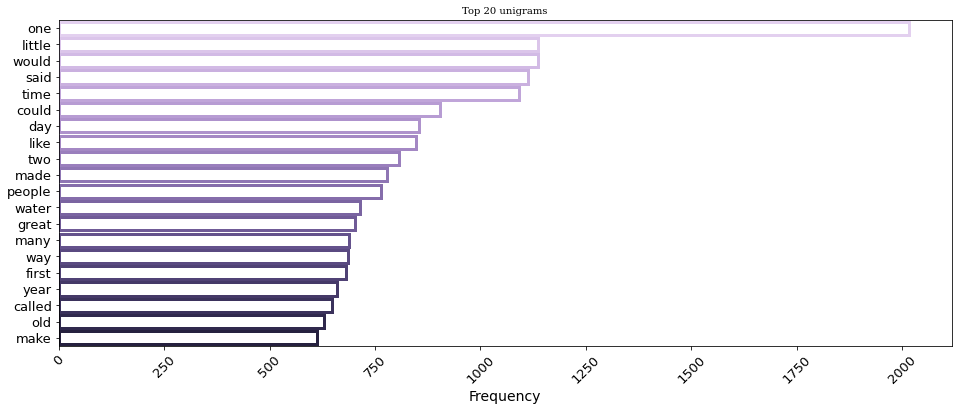

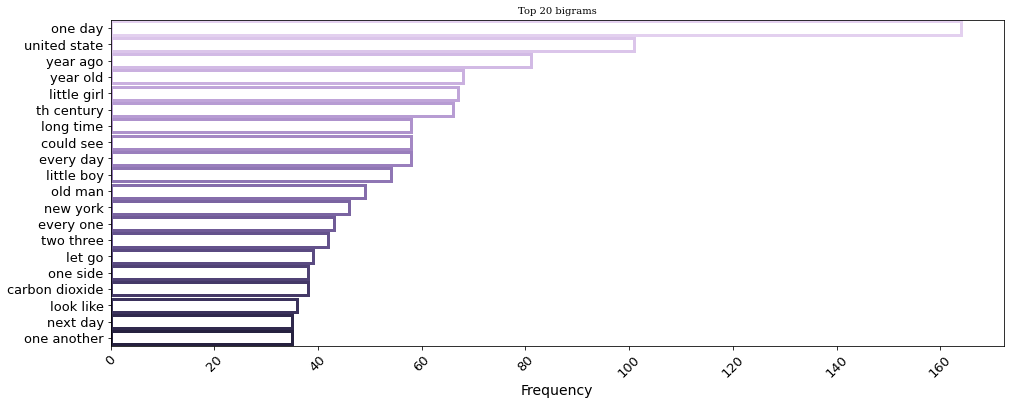

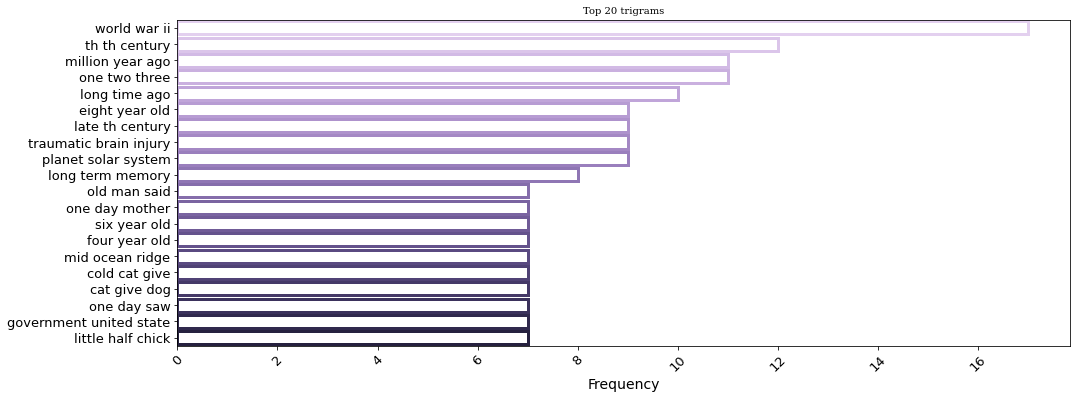

In [21]:
common_words = get_top_n_words(train_df['preprocessed_excerpt'], 20)
common_words_df1 = pd.DataFrame(common_words,columns=['word','freq'])
plt.figure(figsize=(16, 6))
ax = sns.barplot(x='freq', y='word', data=common_words_df1,
                 facecolor=(0, 0, 0, 0),linewidth=3,
                 edgecolor=sns.color_palette("ch:start=3, rot=.1",20))

plt.title("Top 20 unigrams",font='Serif')
plt.xlabel("Frequency", fontsize=14)
plt.yticks(fontsize=13)
plt.xticks(rotation=45, fontsize=13)
plt.ylabel("");

common_words = get_top_n_bigram(train_df['preprocessed_excerpt'], 20)
common_words_df2 = pd.DataFrame(common_words,columns=['word','freq'])
plt.figure(figsize=(16, 6))
ax = sns.barplot(x='freq', y='word', data=common_words_df2,
                 facecolor=(0, 0, 0, 0),linewidth=3,
                 edgecolor=sns.color_palette("ch:start=3, rot=.1",20))

plt.title("Top 20 bigrams",font='Serif')
plt.xlabel("Frequency", fontsize=14)
plt.yticks(fontsize=13)
plt.xticks(rotation=45, fontsize=13)
plt.ylabel("");

common_words = get_top_n_trigram(train_df['preprocessed_excerpt'], 20)
common_words_df2 = pd.DataFrame(common_words,columns=['word','freq'])
plt.figure(figsize=(16, 6))
ax = sns.barplot(x='freq', y='word', data=common_words_df2,
                 facecolor=(0, 0, 0, 0),linewidth=3,
                 edgecolor=sns.color_palette("ch:start=3, rot=.1",20))

plt.title("Top 20 trigrams",font='Serif')
plt.xlabel("Frequency", fontsize=14)
plt.yticks(fontsize=13)
plt.xticks(rotation=45, fontsize=13)
plt.ylabel("");

trigram の２位に登場する "th" は stop words に加えたほうがよい？

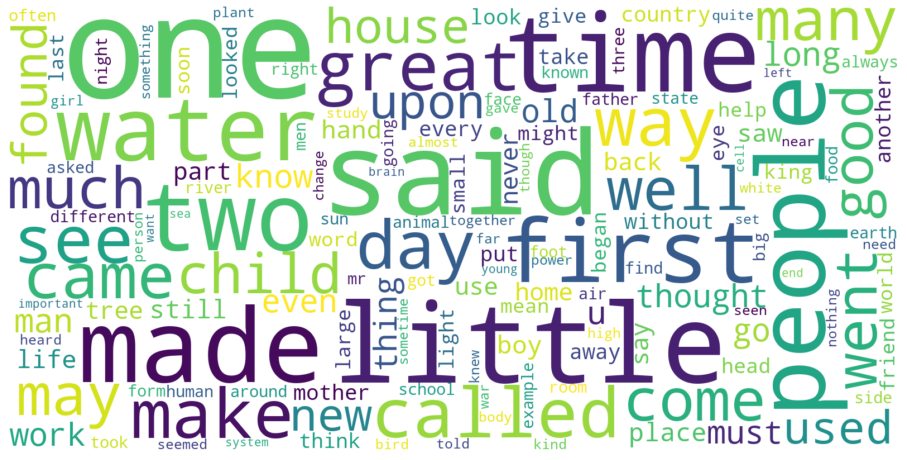

In [22]:
plt.subplots(figsize=(16,16))
wc = WordCloud(stopwords=STOPWORDS,background_color="white", 
               contour_width=2, contour_color='blue', width=1600, height=800,
               max_words=150, max_font_size=256,random_state=42)
wc.generate(' '.join(train_df['preprocessed_excerpt']))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

stop words に 入れたほうがよいword:u 
動詞は過去形のものも残っている

In [23]:
def avg_word_len(df):
    """ 登場する単語の文字数の平均を算出する """
    df = df.str.split().apply(
        lambda x : [len(i) for i in x] # 各単語の文字数
    ).map(lambda x: np.mean(x)) # 文字数の平均
    return df

In [24]:
train_df['excerpt'][0]

'When the young people returned to the ballroom, it presented a decidedly changed appearance. Instead of an interior scene, it was a winter landscape.\nThe floor was covered with snow-white canvas, not laid on smoothly, but rumpled over bumps and hillocks, like a real snow field. The numerous palms and evergreens that had decorated the room, were powdered with flour and strewn with tufts of cotton, like snow. Also diamond dust had been lightly sprinkled on them, and glittering crystal icicles hung from the branches.\nAt each end of the room, on the wall, hung a beautiful bear-skin rug.\nThese rugs were for prizes, one for the girls and one for the boys. And this was the game.\nThe girls were gathered at one end of the room and the boys at the other, and one end was called the North Pole, and the other the South Pole. Each player was given a small flag which they were to plant on reaching the Pole.\nThis would have been an easy matter, but each traveller was obliged to wear snowshoes.'

In [25]:
!pip install textstat
import textstat

     |████████████████████████████████| 99 kB 785 kB/s 
     |████████████████████████████████| 2.0 MB 2.9 MB/s 


In [26]:
# 文字数 // number of characters in the text
text_len = train_df['excerpt'].str.len()
text_len_pre = train_df['preprocessed_excerpt'].str.len()
text_len_dif = train_df['excerpt'].str.len() - train_df['preprocessed_excerpt'].str.len()

# 単語の文字数の平均 // average of number of characters in words present in the text
avg_text = avg_word_len(train_df['excerpt'])
avg_text_pre = avg_word_len(train_df['preprocessed_excerpt'])

# 単語数 // number of words present in the text
lexicon_count = [] 
lexicon_count_pre = []
lexicon_count_dif = []
# 文章数 // number of sentences present in the text
sentence_count = []
# 文章あたりの単語数 // mean/max/min number of words in each sentence
mean_lexicon_count_per_st = []
max_lexicon_count_per_st = []
min_lexicon_count_per_st = []

for i in range(len(train_df)):
    lc = textstat.lexicon_count(train_df['excerpt'][i])
    lcp = textstat.lexicon_count(train_df['preprocessed_excerpt'][i])
    lcd = lc - lcp
    sc = textstat.sentence_count(train_df['excerpt'][i])
    lexicon_count.append(lc)
    lexicon_count_pre.append(lcp)
    lexicon_count_dif.append(lcd)
    sentence_count.append(sc)
    mean_lexicon_count_per_st.append(np.mean([textstat.lexicon_count(x) for x in train_df['excerpt'][i].split(".")]))
    max_lexicon_count_per_st.append(np.max([textstat.lexicon_count(x) for x in train_df['excerpt'][i].split(".")]))
    min_lexicon_count_per_st.append(np.min([textstat.lexicon_count(x) for x in train_df['excerpt'][i].split(".") if textstat.lexicon_count(x) > 1]))

In [27]:
text_props = train_df.copy()
text_props['text_len'] = text_len
text_props['text_len_pre'] = text_len_pre
text_props['text_len_dif'] = text_len_dif
text_props['lexicon_count'] = lexicon_count
text_props['lexicon_count_pre'] = lexicon_count_pre
text_props['lexicon_count_dif'] = lexicon_count_dif # preprocess と original の差
text_props['avg_text'] = avg_text
text_props['avg_text_pre'] = avg_text_pre
text_props['sentence_count'] = sentence_count
text_props['mean_lexicon_count_per_st'] = mean_lexicon_count_per_st
text_props['max_lexicon_count_per_st'] = max_lexicon_count_per_st
text_props['min_lexicon_count_per_st'] = min_lexicon_count_per_st
text_props.head(3)

id url_legal license  \
0  c12129c31       NaN     NaN   
1  85aa80a4c       NaN     NaN   
2  b69ac6792       NaN     NaN   

                                             excerpt    target  \
0  When the young people returned to the ballroom... -0.340259   
1  All through dinner time, Mrs. Fayre was somewh... -0.315372   
2  As Roger had predicted, the snow departed as q... -0.580118   

   standard_error                               preprocessed_excerpt  \
0        0.464009  young people returned ballroom presented decid...   
1        0.480805  dinner time mr fayre somewhat silent eye resti...   
2        0.476676  roger predicted snow departed quickly came two...   

   text_len  text_len_pre  text_len_dif  lexicon_count  lexicon_count_pre  \
0       992           591           401            179                 91   
1       937           551           386            169                 85   
2       908           527           381            166                 84   

   lexicon_count_dif  avg_text  avg_text_pre  sentence_count  \
0                 88  4.547486      5.505495              11   
1                 84  4.550296      5.494118              12   
2                 82  4.475904      5.285714               8   

   mean_lexicon_count_per_st  max_lexicon_count_per_st  \
0                  14.916667                        30   
1                  15.363636                        27   
2                  13.833333                        31   

   min_lexicon_count_per_st  
0                         5  
1                         2  
2                         3

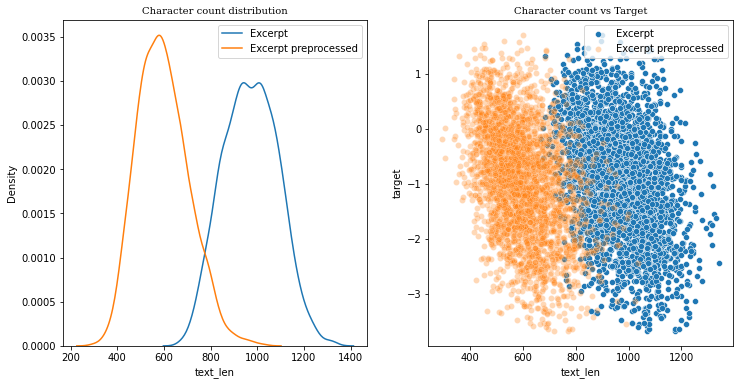

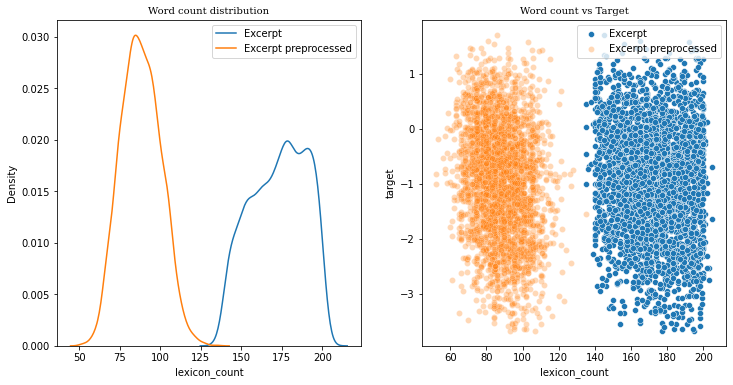

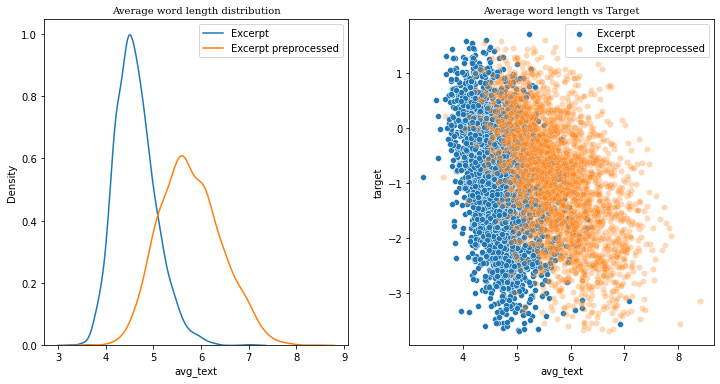

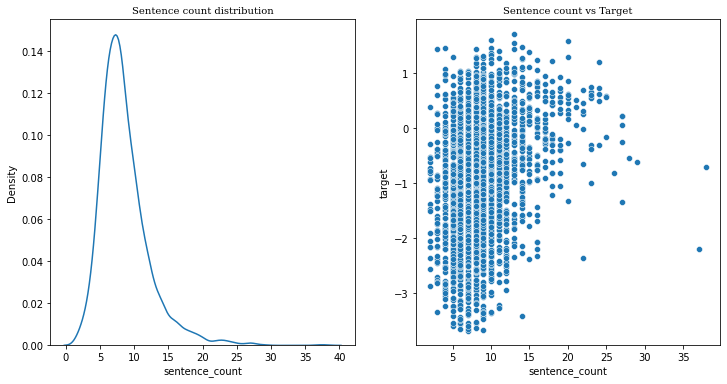

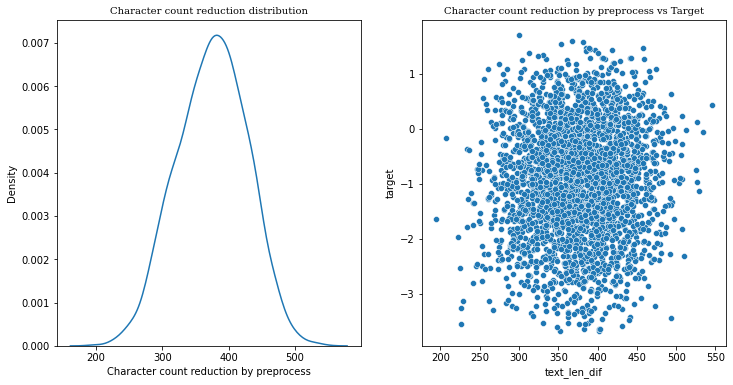

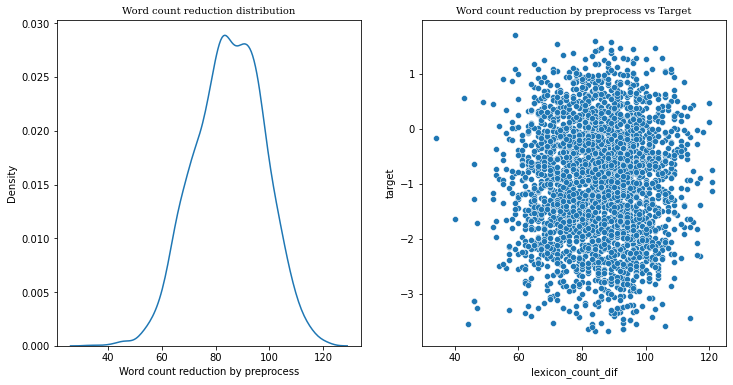

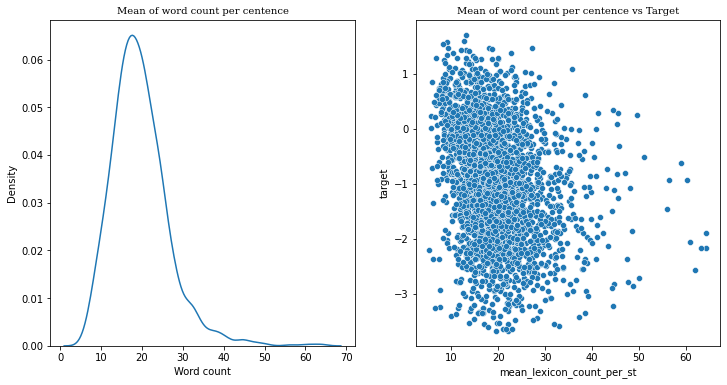

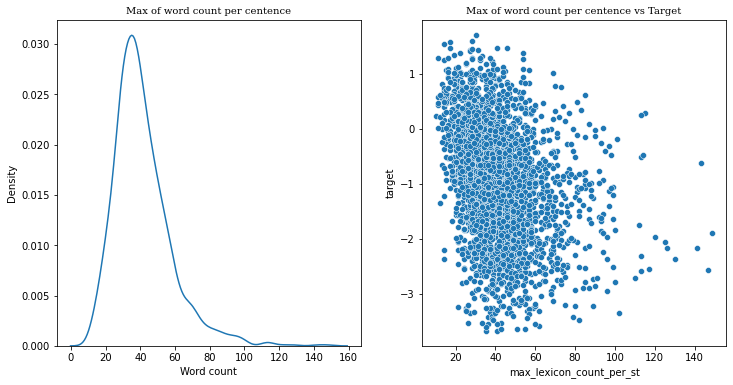

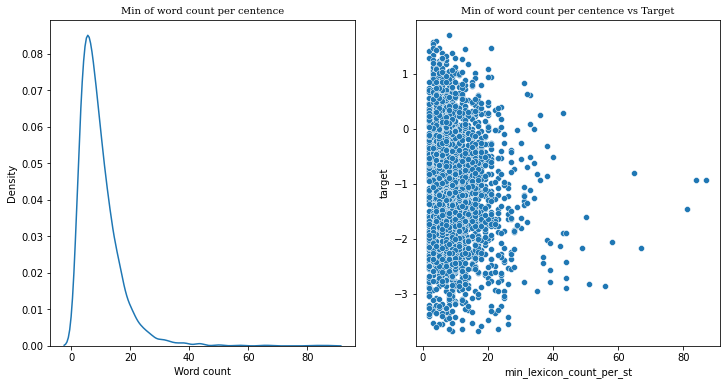

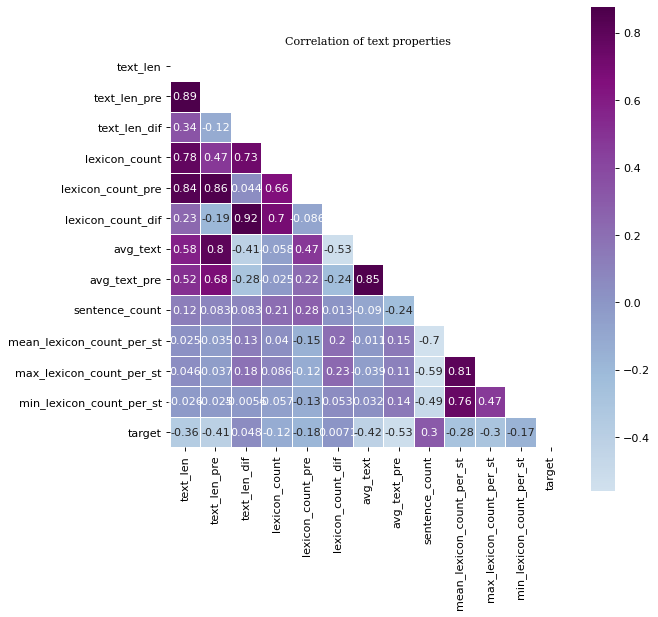

In [28]:
def plot_distribution(col1,col2,title1,title2):
    fig, ax = plt.subplots(1,2,figsize=(12,6))
    sns.kdeplot(data=text_props, x=col1,label="Excerpt",ax=ax[0])
    sns.kdeplot(data=text_props, x=col2,label="Excerpt preprocessed",ax=ax[0])
    ax[0].set_title(title1,font="Serif")
    ax[0].legend()

    sns.scatterplot(data=text_props,x=col1,y='target',label="Excerpt",ax=ax[1],markers='.')
    sns.scatterplot(data=text_props,x=col2,y='target',label="Excerpt preprocessed", ax=ax[1],markers='.', alpha=0.3)
    ax[1].set_title(title2,font="Serif")
    ax[1].legend()

    plt.show()

plot_distribution("text_len","text_len_pre","Character count distribution","Character count vs Target")
plot_distribution("lexicon_count","lexicon_count_pre","Word count distribution","Word count vs Target")
plot_distribution("avg_text","avg_text_pre", "Average word length distribution","Average word length vs Target")

fig, ax = plt.subplots(1,2,figsize=(12,6))
sns.kdeplot(data=text_props, x=sentence_count,label="Excerpt",ax=ax[0])
ax[0].set_title("Sentence count distribution",font="Serif")
ax[0].set_xlabel("sentence_count")
sns.scatterplot(data=text_props,x='sentence_count',y='target',ax=ax[1],markers='.')
ax[1].set_title("Sentence count vs Target",font="Serif")
plt.show()

fig, ax = plt.subplots(1,2,figsize=(12,6))
sns.kdeplot(data=text_props, x=text_len_dif,label="Excerpt",ax=ax[0])
ax[0].set_title("Character count reduction distribution",font="Serif")
ax[0].set_xlabel("Character count reduction by preprocess")
sns.scatterplot(data=text_props,x='text_len_dif',y='target',ax=ax[1],markers='.')
ax[1].set_title("Character count reduction by preprocess vs Target",font="Serif")
plt.show()

fig, ax = plt.subplots(1,2,figsize=(12,6))
sns.kdeplot(data=text_props, x=lexicon_count_dif,label="Excerpt",ax=ax[0])
ax[0].set_title("Word count reduction distribution",font="Serif")
ax[0].set_xlabel("Word count reduction by preprocess")
sns.scatterplot(data=text_props,x='lexicon_count_dif',y='target',ax=ax[1],markers='.')
ax[1].set_title("Word count reduction by preprocess vs Target",font="Serif")
plt.show()

fig, ax = plt.subplots(1,2,figsize=(12,6))
sns.kdeplot(data=text_props, x=mean_lexicon_count_per_st,label="Excerpt",ax=ax[0])
ax[0].set_title("Mean of word count per centence",font="Serif")
ax[0].set_xlabel("Word count")
sns.scatterplot(data=text_props,x='mean_lexicon_count_per_st',y='target',ax=ax[1],markers='.')
ax[1].set_title("Mean of word count per centence vs Target",font="Serif")
plt.show()

fig, ax = plt.subplots(1,2,figsize=(12,6))
sns.kdeplot(data=text_props, x=max_lexicon_count_per_st,label="Excerpt",ax=ax[0])
ax[0].set_title("Max of word count per centence",font="Serif")
ax[0].set_xlabel("Word count")
sns.scatterplot(data=text_props,x='max_lexicon_count_per_st',y='target',ax=ax[1],markers='.')
ax[1].set_title("Max of word count per centence vs Target",font="Serif")
plt.show()

fig, ax = plt.subplots(1,2,figsize=(12,6))
sns.kdeplot(data=text_props, x=min_lexicon_count_per_st,label="Excerpt",ax=ax[0])
ax[0].set_title("Min of word count per centence",font="Serif")
ax[0].set_xlabel("Word count")
sns.scatterplot(data=text_props,x='min_lexicon_count_per_st',y='target',ax=ax[1],markers='.')
ax[1].set_title("Min of word count per centence vs Target",font="Serif")
plt.show()

num_cols = ['text_len','text_len_pre','text_len_dif', 
            'lexicon_count','lexicon_count_pre','lexicon_count_dif', 
            'avg_text','avg_text_pre','sentence_count',
            'mean_lexicon_count_per_st', 'max_lexicon_count_per_st', 'min_lexicon_count_per_st',
            'target']
corr = text_props[num_cols].corr()

fig = plt.figure(figsize=(8,8),dpi=80)
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='BuPu', robust=True, center=0, annot=True,
            square=True, linewidths=.5)
plt.title('Correlation of text properties', fontsize=15,font="Serif")
plt.show()

- avg_text (単語の文字数の平均)やtext_len（文字数）は target と負の相関→文字数が少ないほど読みやすい
- sentence_count（文章の数）は、target と弱い正の相関→文章数が少ないほど読みやすい
- いずれも直観的な感覚と一致する

### 文章中に登場する単語の品詞をカウントする

In [29]:
text_props['pos_tags'] = text_props['preprocessed_excerpt'].str.split().map(pos_tag)

print(text_props['preprocessed_excerpt'][0][:50])
print(text_props['pos_tags'][0][:5])

young people returned ballroom presented decidedly
[('young', 'JJ'), ('people', 'NNS'), ('returned', 'VBD'), ('ballroom', 'RB'), ('presented', 'VBN')]


In [30]:
def count_tags(pos_tags):
    tag_count = {}
    for word,tag in pos_tags:
        if tag in tag_count:
            tag_count[tag] += 1
        else:
            tag_count[tag] = 1
    return tag_count

text_props['tag_counts'] = text_props['pos_tags'].map(count_tags)
print(text_props['tag_counts'].head())

0    {'JJ': 17, 'NNS': 2, 'VBD': 7, 'RB': 6, 'VBN':...
1    {'NN': 24, 'JJ': 21, 'RB': 14, 'VBG': 2, 'VBD'...
2    {'NN': 29, 'VBD': 7, 'JJ': 17, 'RB': 15, 'CD':...
3    {'JJ': 22, 'NN': 47, 'VBD': 8, 'VBN': 3, 'RB':...
4    {'IN': 2, 'NN': 23, 'CD': 3, 'VBD': 5, 'RB': 1...
Name: tag_counts, dtype: object


'JJ' とか 'NNS' とかが品詞の種類、後に続く value が登場回数を表す

定義はoriginal kernel 参照

https://www.kaggle.com/ruchi798/commonlit-readability-prize-eda-baseline/comments?scriptVersionId=62607090&cellId=47

In [31]:
set_pos = set([tag for tags in text_props['tag_counts'] for tag in tags])
tag_cols = list(set_pos)

for tag in tag_cols:
    text_props[tag] = text_props['tag_counts'].map(lambda x: x.get(tag, 0))
text_props[tag_cols].head()

SYM  WDT  CC  RBR  JJR  ''  WP  NNPS  EX  JJ  ...  VBD  RB  VBG  PRP$  RBS  \
0    0    0   0    0    0   0   0     0   0  17  ...    7   6    2     0    0   
1    0    0   0    0    0   0   0     0   0  21  ...    7  14    2     0    0   
2    0    0   0    0    0   0   0     0   0  17  ...    7  15    1     0    0   
3    0    0   0    0    0   0   0     0   0  22  ...    8   5    2     0    0   
4    0    0   0    0    0   0   0     0   0  36  ...    5   1    0     0    0   

   VBP  UH  VBN  PRP  WRB  
0    0   0    6    0    0  
1    5   0    3    0    0  
2    2   0    5    0    0  
3    2   0    3    0    0  
4    0   0    4    0    0  

[5 rows x 37 columns]

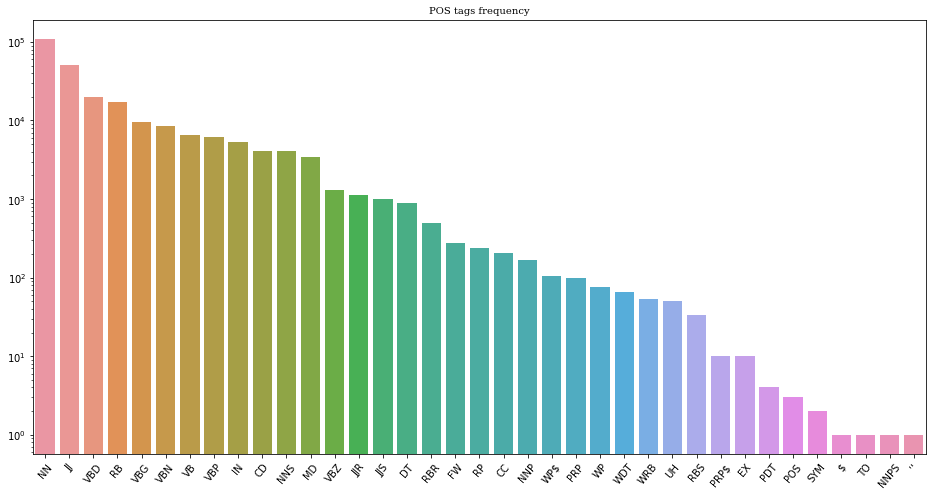

In [32]:
pos = text_props[tag_cols].sum().sort_values(ascending = False)
plt.figure(figsize=(16,8))
ax = sns.barplot(x=pos.index, y=pos.values)
plt.xticks(rotation = 50)
ax.set_yscale('log')
plt.title('POS tags frequency',fontsize=15,font="Serif")
plt.show()

- [original の kernel](https://www.kaggle.com/ruchi798/commonlit-readability-prize-eda-baseline/comments?scriptVersionId=62607090&cellId=54)によると、textstat には読みやすさに関するスコアの算出方法が実装されているそうな


In [33]:
flesch_re, flesch_kg, fog_scale, automated_r,coleman, linsear, text_standard  = ([] for i in range(7))
for i in range(len(text_props)):
    flr = textstat.flesch_reading_ease(train_df['excerpt'][i])
    flkg = textstat.flesch_kincaid_grade(train_df['excerpt'][i])
    fs = textstat.gunning_fog(train_df['excerpt'][i])
    ar = textstat.automated_readability_index(train_df['excerpt'][i])
    cole = textstat.coleman_liau_index(train_df['excerpt'][i])
    lins = textstat.linsear_write_formula(train_df['excerpt'][i])
    ts = textstat.text_standard(train_df['excerpt'][i])
    
    flesch_re.append(flr)
    flesch_kg.append(flkg)
    fog_scale.append(fs)
    automated_r.append(ar)
    coleman.append(cole)
    linsear.append(lins)
    text_standard.append(ts)
    
text_props['flesch_re'] = flesch_re
text_props['flesch_kg'] = flesch_kg
text_props['fog_scale'] = fog_scale
text_props['automated_r'] = automated_r
text_props['coleman'] = coleman
text_props['linsear'] = linsear
text_props['text_standard'] = text_standard

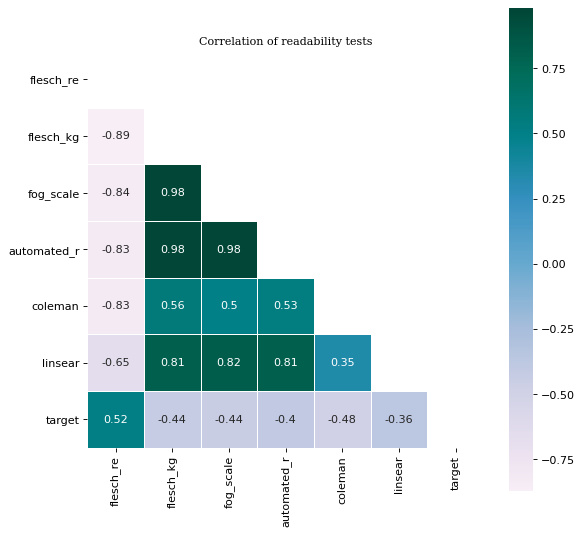

In [34]:
readability_cols = ['flesch_re','flesch_kg','fog_scale','automated_r','coleman','linsear','text_standard','target']

corr = text_props[readability_cols].corr()
fig = plt.figure(figsize=(8,8),dpi=80)
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='PuBuGn', robust=True, center=0,
            square=True, linewidths=.5,annot=True)
plt.title('Correlation of readability tests', fontsize=15,font="Serif")
plt.show()

Flesch Readability Ease の値と target には正の相関

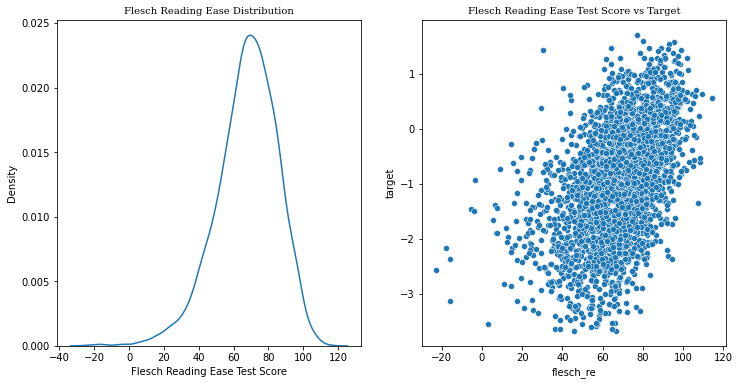

In [35]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
sns.kdeplot(data=text_props, x=flesch_re,ax=ax[0])
ax[0].set_title("Flesch Reading Ease Distribution",font="Serif")
ax[0].set_xlabel("Flesch Reading Ease Test Score")
sns.scatterplot(data=text_props,x='flesch_re',y='target',ax=ax[1],markers='.')
ax[1].set_title("Flesch Reading Ease Test Score vs Target",font="Serif")
plt.show()

In [36]:
print(text_props.columns)
text_props.head()

Index(['id', 'url_legal', 'license', 'excerpt', 'target', 'standard_error',
       'preprocessed_excerpt', 'text_len', 'text_len_pre', 'text_len_dif',
       'lexicon_count', 'lexicon_count_pre', 'lexicon_count_dif', 'avg_text',
       'avg_text_pre', 'sentence_count', 'mean_lexicon_count_per_st',
       'max_lexicon_count_per_st', 'min_lexicon_count_per_st', 'pos_tags',
       'tag_counts', 'SYM', 'WDT', 'CC', 'RBR', 'JJR', '''', 'WP', 'NNPS',
       'EX', 'JJ', 'NNS', 'FW', 'RP', 'NN', 'VBZ', 'VB', 'NNP', 'TO', 'JJS',
       'MD', 'CD', 'IN', 'POS', 'WP$', 'PDT', '$', 'DT', 'VBD', 'RB', 'VBG',
       'PRP$', 'RBS', 'VBP', 'UH', 'VBN', 'PRP', 'WRB', 'flesch_re',
       'flesch_kg', 'fog_scale', 'automated_r', 'coleman', 'linsear',
       'text_standard'],
      dtype='object')


id url_legal license  \
0  c12129c31       NaN     NaN   
1  85aa80a4c       NaN     NaN   
2  b69ac6792       NaN     NaN   
3  dd1000b26       NaN     NaN   
4  37c1b32fb       NaN     NaN   

                                             excerpt    target  \
0  When the young people returned to the ballroom... -0.340259   
1  All through dinner time, Mrs. Fayre was somewh... -0.315372   
2  As Roger had predicted, the snow departed as q... -0.580118   
3  And outside before the palace a great garden w... -1.054013   
4  Once upon a time there were Three Bears who li...  0.247197   

   standard_error                               preprocessed_excerpt  \
0        0.464009  young people returned ballroom presented decid...   
1        0.480805  dinner time mr fayre somewhat silent eye resti...   
2        0.476676  roger predicted snow departed quickly came two...   
3        0.450007  outside palace great garden walled round fille...   
4        0.510845  upon time three bear lived together house wood...   

   text_len  text_len_pre  text_len_dif  ...  VBN  PRP  WRB  flesch_re  \
0       992           591           401  ...    6    0    0      80.31   
1       937           551           386  ...    3    0    0      82.54   
2       908           527           381  ...    5    0    0      75.74   
3       909           573           336  ...    3    0    0      72.02   
4       723           413           310  ...    4    0    0      75.47   

   flesch_kg  fog_scale  automated_r  coleman    linsear        text_standard  
0        6.1       8.31          8.3     8.06   9.000000    8th and 9th grade  
1        5.2       7.53          7.2     6.78   7.285714    7th and 8th grade  
2        7.9      10.49         10.1     7.20  14.750000    7th and 8th grade  
3       11.4      13.61         16.4     8.54  12.500000    6th and 7th grade  
4       10.0      11.76         11.8     4.83  13.500000  11th and 12th grade  

[5 rows x 65 columns]